# Simulation-based inference with `sbijax`

Here we demonstrate a selected set of inferential algorithms.

Interactive online version of this notebook:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dirmeier/sbijax/blob/main/docs/notebooks/sbi_with_sbijax.ipynb)

In [1]:
import jax
import sbijax
%matplotlib inline
import matplotlib.pyplot as plt

In [38]:
import arviz as az

def plot_posteriors(obj):
    _, axes = plt.subplots(nrows=5, ncols=5)
    with az.style.context(["arviz-doc"], after_reset=True):
        for i in range(0, 5):        
            for j in range(0, 5):
                ax = axes[i, j]
                if i < j:
                    ax.axis('off')
                else:
                    ax.hexbin(obj[..., j], obj[..., i], gridsize=50, bins='log', cmap='viridis')            
                ax.spines.left.set_linewidth(.5)
                ax.spines.bottom.set_linewidth(.5)
                ax.spines.right.set_linewidth(.5)
                ax.spines.top.set_linewidth(.5)       
                if i < 4:                    
                    ax.set_xticklabels([])
                    ax.xaxis.set_tick_params(width=0., length=0)
                if j != 0:                    
                    ax.set_yticklabels([])
                    ax.yaxis.set_tick_params(width=0., length=0)
                ax.grid(which='major', axis='both', alpha=0.5)
        for i in range(5):
            axes[i, i].hist(obj[..., i], color="black")
    plt.tight_layout()
    plt.show()

## Model

We use the infamous simple likelihood comples posterior model which is a common experimental benchmark for SBI methods as an example:

\begin{align}
\theta_i &\sim \text{Uniform}(-3, 3) \; \text{for} \; i=1, \dots, 5\\
\mu( {\theta}) &= (\theta_1, \theta_2), \phi_1 = \theta_3^2 , \phi_2 = \theta_4^2 \\
\Sigma( {\theta} ) &=
\begin{pmatrix}
\phi_1^2 & \text{tanh}(\theta_5) \phi_1 \phi_2 \\
\text{tanh}(\theta_5) \phi_1 \phi_2 & \phi_2^2
\end{pmatrix}\\
{y}_j | {\theta}  &\sim \mathcal{N}({y}_j; \mu( {\theta}), \Sigma( {\theta})) \; \text{for} \; j=1, \dots, 4\\
{y} &= [{y}_1, \dots, {y}_4]^T
\end{align}

The observation model is parameterized by a five-dimensional random variable $\theta \sim \pi(\theta)$ for which we want to infer the posterior distribution $\pi(\theta | y_{\text{obs}}) \propto \pi(y_{\text{obs}} | \theta) \pi(\theta)$ for a specific eight-dimensional observation $y_{\text{obs}}$.

Translated into code it looks like this:

In [3]:
from jax import numpy as jnp, random as jr
from tensorflow_probability.substrates.jax import distributions as tfd


def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        theta=tfd.Uniform(jnp.full(5, -3.0), jnp.full(5, 3.0))
    ), batch_ndims=0)
    return prior


def simulator_fn(seed, theta):
    theta = theta["theta"]
    orig_shape = theta.shape
    if theta.ndim == 2:
        theta = theta[:, None, :]
    us_key, noise_key = jr.split(seed)

    def _unpack_params(ps):
        m0 = ps[..., [0]]
        m1 = ps[..., [1]]
        s0 = ps[..., [2]] ** 2
        s1 = ps[..., [3]] ** 2
        r = jnp.tanh(ps[..., [4]])
        return m0, m1, s0, s1, r

    m0, m1, s0, s1, r = _unpack_params(theta)
    us = tfd.Normal(0.0, 1.0).sample(
        seed=us_key, sample_shape=(theta.shape[0], theta.shape[1], 4, 2)
    )
    xs = jnp.empty_like(us)
    xs = xs.at[:, :, :, 0].set(s0 * us[:, :, :, 0] + m0)
    y = xs.at[:, :, :, 1].set(
        s1 * (r * us[:, :, :, 0] + jnp.sqrt(1.0 - r**2) * us[:, :, :, 1]) + m1
    )
    if len(orig_shape) == 2:
        y = y.reshape((*theta.shape[:1], 8))
    else:
        y = y.reshape((*theta.shape[:2], 8))
    return y

As an observation $y_{\text{obs}}$, we use the one that is used in the literature, too.

In [6]:
y_obs = jnp.array([[
    -0.9707123,
    -2.9461224,
    -0.4494722,
    -3.4231849,
    -0.13285634,
    -3.364017,
    -0.85367596,
    -2.4271638,
]])

## Likelihood estimation

We start with an algorithm that aims to approximate the likelihood function of the model. NLE methods require a density estimator that models a space with the same dimensionality as the *data* space. We use a masked autoregressive flow to model that space.

In [33]:
from sbijax.nn import make_maf

n_dim_data = y_obs.shape[-1]
neural_network = make_maf(n_dim_data)

In [34]:
from sbijax import NLE

fns = prior_fn, simulator_fn
nle = NLE(fns, neural_network)

We then do inference sequentially in 10 rounds.

In [35]:
data, nle_params = None, {}
for i in range(10):
    data, _ = nle.simulate_data_and_possibly_append(
        jr.fold_in(jr.PRNGKey(1), i),
        params=nle_params,
        observable=y_obs,
        data=data
    )
    nle_params, info = nle.fit(
        jr.fold_in(jr.PRNGKey(2), i), data=data
    )

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 517/1000 [02:09<02:01,  3.98it/s]


In [36]:
nle_inference_results, _ = nle.sample_posterior(
    jr.PRNGKey(3), nle_params, y_obs, n_samples=10_000, n_warmup=5000, n_chains=4
)

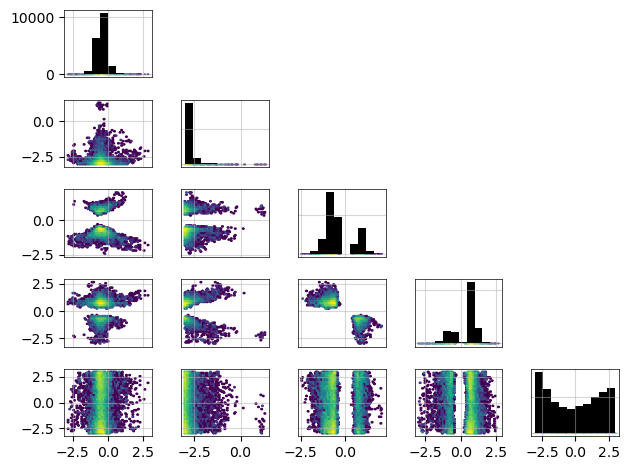

In [39]:
plot_posteriors(sbijax.inference_data_as_dictionary(nle_inference_results.posterior)["theta"])

## Posterior estimation

In [6]:
from sbijax import FMPE
from sbijax.nn import make_ccnf, make_consistency_model

In [7]:
n_dim_theta = 5
n_layers, hidden_size = 5, 128
neural_network = make_ccnf(n_dim_theta, n_layers, hidden_size)
fns = prior_fn, simulator_fn
fmpe = SFMPE(fns, neural_network)

In [11]:
data, fmpe_params = None, {}
for i in range(1):
    data, _ = fmpe.simulate_data_and_possibly_append(
        jr.fold_in(jr.PRNGKey(1), i),
        params=fmpe_params,
        observable=obs,
        data=data,
        n_simulations=20_000,
    )
    fmpe_params, info = fmpe.fit(
        jr.fold_in(jr.PRNGKey(2), i), data=data, optimizer=optax.adam(0.001), n_early_stopping_delta=0.00001, n_early_stopping_patience=30
    )

 12%|███████████████▊                                                                                                                    | 120/1000 [02:13<16:15,  1.11s/it]


In [12]:
fmpe_inference_results, diagnostics = fmpe.sample_posterior(
    jr.PRNGKey(1), fmpe_params, obs, n_samples=25_000
)

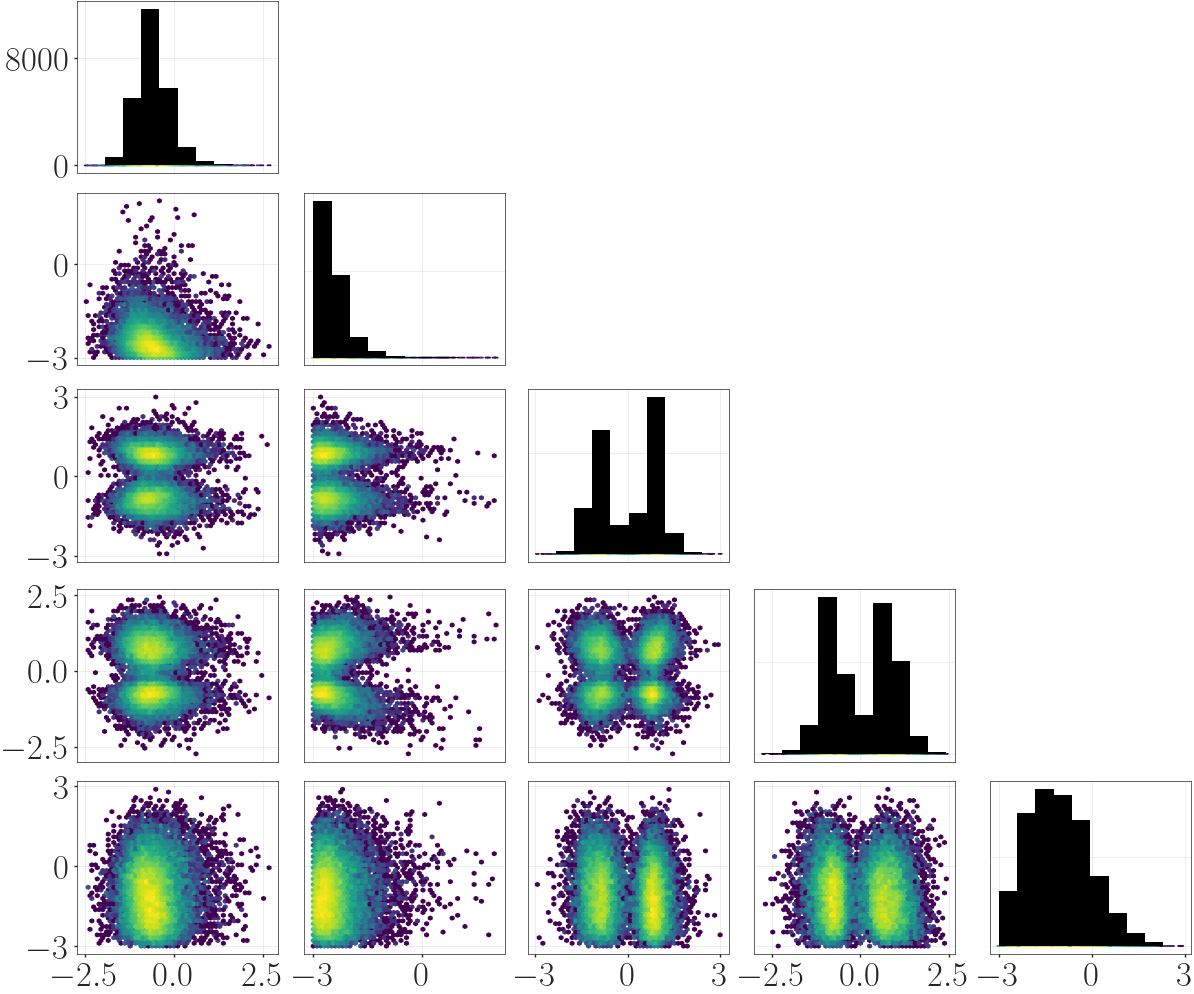

In [13]:
plot_posteriors(
    sbijax._src.mcmc.util.flatten(fmpe_inference_results.posterior)["theta"],
    "/Users/simon/PROJECTS/2022-bistom/docs/manuscript/sbijax/figures/posterior_pair_plot-fmpe.pdf"
)

## Likelihood-ratio estimation

In [8]:
from sbijax import NASS, SMCABC, inference_data_as_dictionary
from sbijax.nn import make_nass_net

In [9]:
fns = prior_fn, simulator_fn
model_nass = NASS(fns, make_nass_net([64, 64, 5], [64, 64, 1]))

data, _ = model_nass.simulate_data(jr.PRNGKey(1), n_simulations=20_000)
params_nass, _ = model_nass.fit(jr.PRNGKey(2), data=data, n_early_stopping_patience=25)

 20%|███████████████████████████                                                                                                               | 196/1000 [02:47<11:25,  1.17it/s]


In [10]:
def distance_fn(y_simulated, y_observed):
    diff = y_simulated - y_observed
    dist = jax.vmap(lambda el: jnp.linalg.norm(el))(diff)
    return dist

def summary_fn(y):
    s = model_nass.summarize(params_nass, y)
    return s

model_smc = SMCABC(fns, summary_fn, distance_fn)

In [13]:
smc_inference_results, _ = model_smc.sample_posterior(
    jr.PRNGKey(3), y_observed, n_rounds=10, n_particles=5_000, eps_step=0.825, ess_min=2_000
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:31<00:00, 39.14s/it]


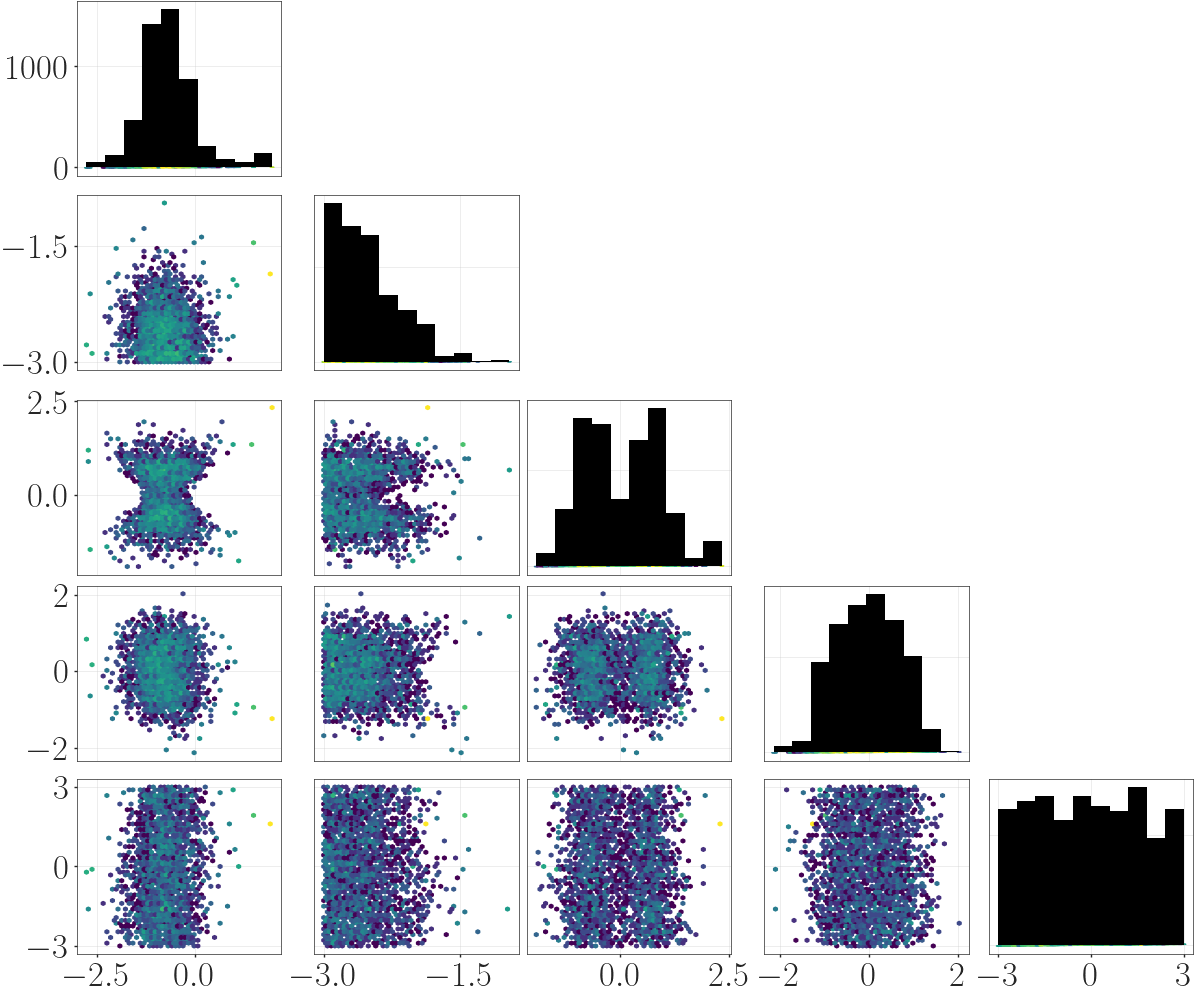

In [14]:
plot_posteriors(
    sbijax._src.mcmc.util.flatten(smc_inference_results.posterior)["theta"],
    "/Users/simon/PROJECTS/2022-bistom/docs/manuscript/sbijax/figures/posterior_pair_plot-smc.pdf"
)